# Traveltime tomography using the Eikonal equation (2D case)

@Author: Ettore Biondi - ebiondi@caltech.edu

In [2]:
import occamypy
import numpy as np
import os
import pkg_resources
import scipy.ndimage
import Eiko2Dmod

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False
}
matplotlib.rcParams.update(params)

In [3]:
# Fast-Marching-Method (FMM)
# dx = dz = 0.05
dx = dz = 0.1
nx = 201
nz = 101
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)
# Velocity model
vv = np.zeros((nx,nz))
vv[:,:] = 1.0 + z*0.1
vv = occamypy.VectorNumpy(vv)

In [4]:
# Source/Receiver positions
SouPos = np.array([[0,nz-1], [int(nx/2), nz-1], [nx-1, nz-1]])
RecPos = np.array([[ix,0] for ix in np.arange(0,nx)])
# Data vector
tt_data = occamypy.VectorNumpy(np.zeros((SouPos.shape[0], RecPos.shape[0])))
# Setting Forward non-linear operator
Eik2D_Op = Eiko2Dmod.EikonalTT_2D(vv, tt_data, dx, dz, SouPos, RecPos)
Eik2D_Op.forward(False, vv, tt_data)

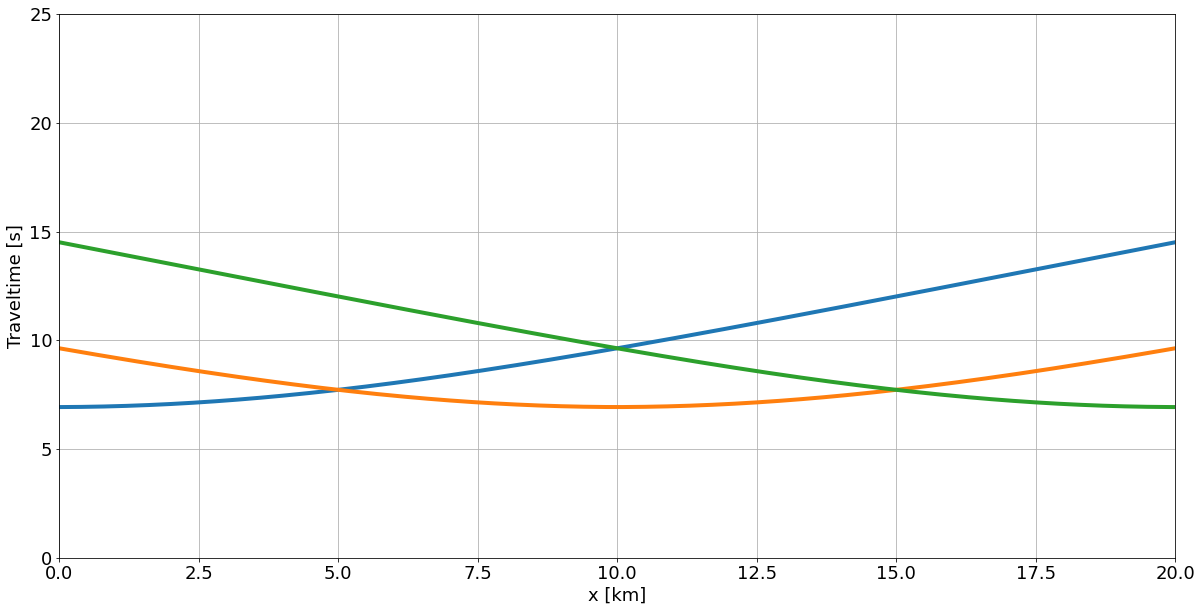

In [5]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(RecPos[:,0]*dx, tt_data.getNdArray()[0, :], lw=4)
ax.plot(RecPos[:,0]*dx, tt_data.getNdArray()[1, :], lw=4)
ax.plot(RecPos[:,0]*dx, tt_data.getNdArray()[2, :], lw=4)
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("Traveltime [s]")
plt.ylim([0.0, 25.0])
ax.autoscale(enable=True, axis='x', tight=True)

In [6]:
# Dot-product test for the linearized Eikonal equation in 1D
Eik2D_Lin_Op = Eiko2Dmod.EikonalTT_lin_2D(vv, tt_data, dx, dz, SouPos, RecPos)
Eik2D_Lin_Op.dotTest(True)

Dot-product tests of forward and adjoint operators
--------------------------------------------------
Applying forward operator add=False
 Runs in: 0.3366668224334717 seconds
Applying adjoint operator add=False
 Runs in: 0.4572908878326416 seconds
Dot products add=False: domain=9.081097e-01 range=9.081097e-01 
Absolute error: 7.771561e-16
Relative error: 8.557954e-16 

Applying forward operator add=True
 Runs in: 0.09936404228210449 seconds
Applying adjoint operator add=True
 Runs in: 0.46433520317077637 seconds
Dot products add=True: domain=1.816219e+00 range=1.816219e+00 
Absolute error: 8.881784e-16
Relative error: 4.890259e-16 

-------------------------------------------------


### Inversion

In [7]:
# Fast-Marching-Method (FMM)
# dx = dz = 0.05
dx = dz = 0.1
nx = 201
nz = 101
x = np.linspace(0,(nx-1)*dx, nx)
z = np.linspace(0,(nz-1)*dz, nz)
# Background Velocity model
vv0 = np.zeros((nx,nz))
vv0[:,:] = 1.0 + z*0.1
vv0 = occamypy.VectorNumpy(vv0)
# Gaussian anomaly
zz, xx = np.meshgrid(z, x)
dst = np.sqrt(xx*xx+zz*zz)
sigma = 1.0
xloc = 101*dx
zloc = 51*dz
gauss = np.exp(-( ((xx-xloc)**2 + (zz-zloc)**2) / (2.0*sigma**2)))
# Constructing true model
vv = vv0.clone()
vv.getNdArray()[:] -= gauss*0.5

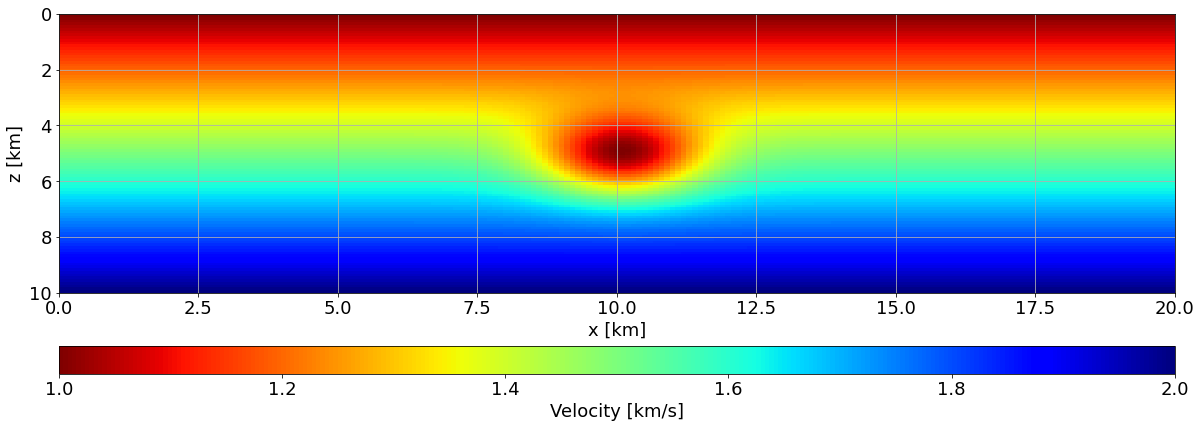

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(vv.getNdArray().T, extent=[x[0], x[-1], z[-1], z[0]],
                cmap=plt.get_cmap("jet_r"), aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("z [km]")
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=-1.2)
cbar = plt.colorbar(im, orientation="horizontal", cax=cax)
cbar.set_label('Velocity [km/s]')

In [9]:
# Source/Receiver positions
SouPos = np.array([[ix,nz-1] for ix in np.arange(0,nx,20)])
RecPos = np.array([[ix,0] for ix in np.arange(0,nx)])
# Data vector
tt_data = occamypy.VectorNumpy(np.zeros((SouPos.shape[0], RecPos.shape[0])))
# Instantiating non-linear operator
Eik2D_Op = Eiko2Dmod.EikonalTT_2D(vv, tt_data, dx, dz, SouPos, RecPos)
Eik2D_Lin_Op = Eiko2Dmod.EikonalTT_lin_2D(vv, tt_data, dx, dz, SouPos, RecPos, tt_maps=Eik2D_Op.tt_maps)
Eik2D_NlOp = occamypy.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op, Eik2D_Lin_Op.set_vel)

In [10]:
# Creating observed data
Eik2D_Op.forward(False, vv, tt_data)
tt_data_obs = tt_data.clone()

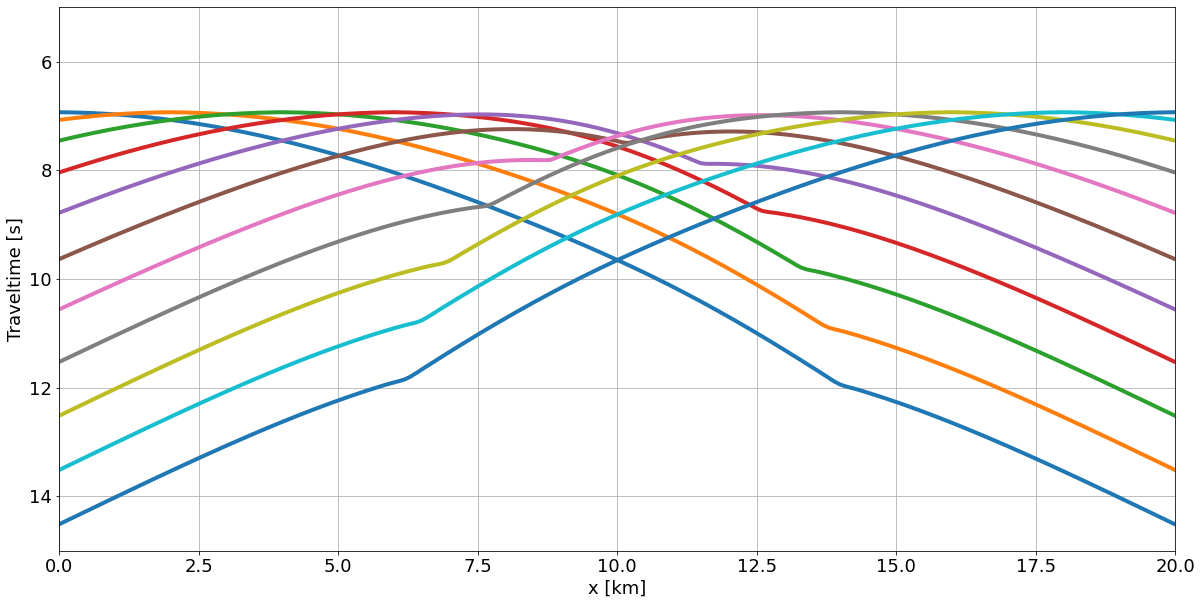

In [11]:
# Plotting traveltime vector
fig, ax = plt.subplots(figsize=(20,10))
for ids in range(SouPos.shape[0]):
    ax.plot(RecPos[:,0]*dx, tt_data.getNdArray()[ids, :], lw=4)
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("Traveltime [s]")
plt.ylim([5.0, 15.0])
ax.autoscale(enable=True, axis='x', tight=True)
ax.invert_yaxis()

In [12]:
v_min = 1.0
v_max = 2.5
minBound = occamypy.VectorNumpy(np.ones((nx,nz))*v_min)
maxBound = occamypy.VectorNumpy(np.ones((nx,nz))*v_max)
niter = 25
Stop  = occamypy.BasicStopper(niter=niter, tolg_proj=1e-32)
BFGSBsolver = occamypy.LBFGS(Stop, m_steps=30)
# Creating problem object using Smoothing filter
SigmaSmooth = 1.5
SmoothOp = Eiko2Dmod.GaussianFilter(vv0, SigmaSmooth)
Eik2D_Inv_NlOp = occamypy.NonlinearOperator(Eik2D_Op, Eik2D_Lin_Op*SmoothOp, Eik2D_Lin_Op.set_vel)
L2_tt_prob = occamypy.NonlinearLeastSquares(vv0.clone(), tt_data_obs, Eik2D_Inv_NlOp, 
                                            minBound=minBound, maxBound=maxBound)

In [13]:
BFGSBsolver.run(L2_tt_prob, verbose=True)

##########################################################################################
Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) algorithm 
Maximum number of steps to be used for Hessian inverse estimation: 30 
Restart folder: /tmp/restart_2022-03-19T22-44-02.954975/
##########################################################################################

iter = 00, obj = 2.48052e+01, resnorm = 7.04e+00, gradnorm = 8.73e+00, feval = 1, geval = 1
iter = 01, obj = 8.19519e+00, resnorm = 4.05e+00, gradnorm = 5.07e+00, feval = 2, geval = 2
iter = 02, obj = 2.58445e+00, resnorm = 2.27e+00, gradnorm = 1.52e+00, feval = 3, geval = 3
iter = 03, obj = 1.23840e+00, resnorm = 1.57e+00, gradnorm = 9.19e-01, feval = 4, geval = 4
iter = 04, obj = 3.15355e-01, resnorm = 7.94e-01, gradnorm = 4.07e-01, feval = 5, geval = 5
iter = 05, obj = 2.03645e-01, resnorm = 6.38e-01, gradnorm = 2.46e-01, feval = 6, geval = 6
iter = 06, obj = 9.79590e-02, resnorm = 4.43e-01, gradnorm = 1.75e-01

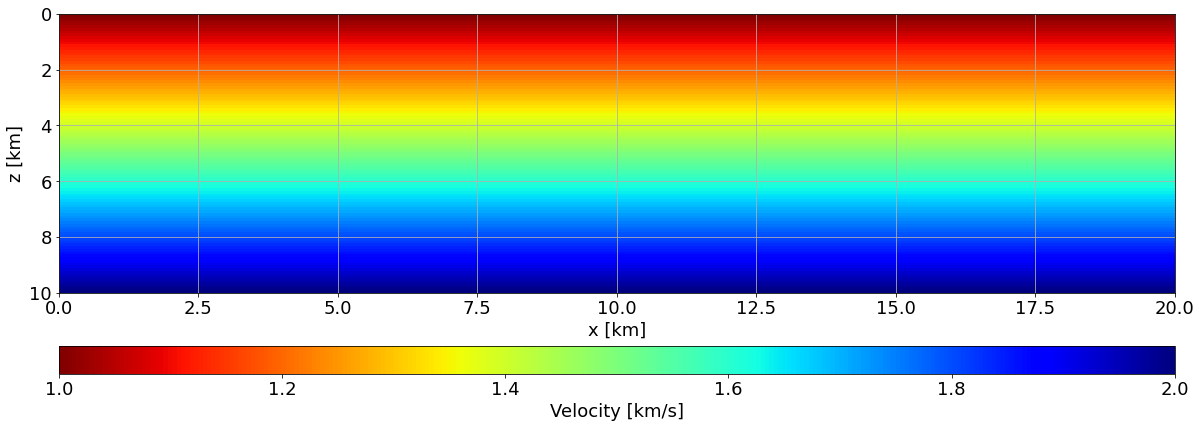

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(vv0.getNdArray().T, extent=[x[0], x[-1], z[-1], z[0]],
                cmap=plt.get_cmap("jet_r"), aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("z [km]")
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=-1.2)
cbar = plt.colorbar(im, orientation="horizontal", cax=cax)
cbar.set_label('Velocity [km/s]')

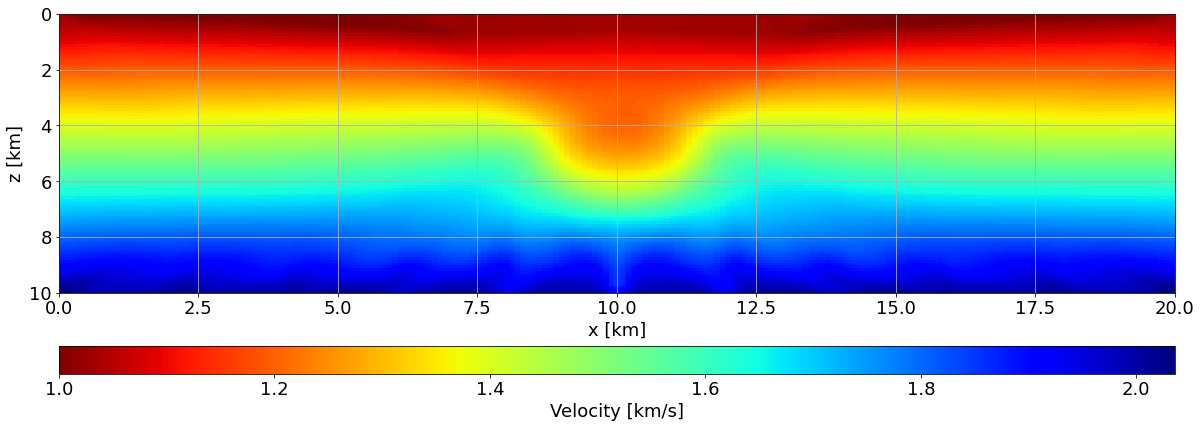

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(L2_tt_prob.model.getNdArray().T, extent=[x[0], x[-1], z[-1], z[0]],
                cmap=plt.get_cmap("jet_r"), aspect=0.5)
ax = plt.gca()
ax.grid()
plt.xlabel("x [km]")
plt.ylabel("z [km]")
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=-1.2)
cbar = plt.colorbar(im, orientation="horizontal", cax=cax)
cbar.set_label('Velocity [km/s]')